# Imports

In [237]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import random as rand

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [238]:
N_EPOCHS = 80
BATCH_SIZE = 32
DATASET_SIZE = 700
TRAIN_DATA_SIZE = int(DATASET_SIZE - (DATASET_SIZE * 0.2))
LATENT_DIM = 128

# Data importing and pre-processing

In [239]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2)


normalize dataset data into range of sigmoid [0,1], and put into batches

In [240]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise random example from dataset

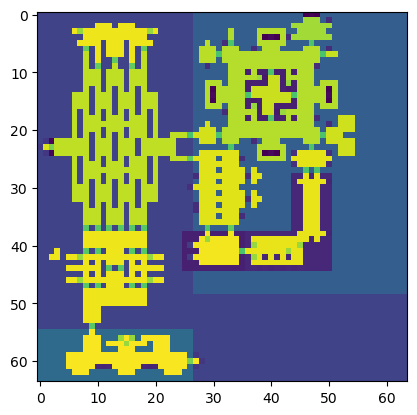

In [241]:
plt.imshow(df[rand.randint(0,DATASET_SIZE)])

# Generator Model

Create points in latent space to be fed into generator

In [242]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [243]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))

    model.add(Dense(100, activation='relu'))
    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [244]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(32, kernel_size=4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [245]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 8192)              1056768   
                                                                 
 batch_normalization_48 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_72 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_12 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 dense_38 (Dense)            (None, 8, 8, 100)         12900     
                                                                 
 conv2d_transpose_48 (Conv2  (None, 16, 16, 128)       204800    
 DTranspose)                                         

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [246]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [247]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [248]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [249]:
gen_optimizer = Adam(learning_rate =0.0001, beta_1=0.4)
disc_optimizer = Adam(learning_rate =0.0001, beta_1=0.4)

Discriminator accuracy

In [250]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output[0] >=0:
        
        if fake_output[0] <0:
            accuracy = (real_output[0] + fake_output[0]) / (real_output[0] + fake_output[0])
        else:
            accuracy = real_output[0]/ (real_output[0] + fake_output[0])
    elif fake_output[0] <0:
        accuracy = fake_output[0] / (real_output[0] + fake_output[0])
    else:
        accuracy = 0/ (real_output[0] + fake_output[0])
    
    return accuracy

## Training

Training step

In [251]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [252]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    
    img_seed = generate_generator_input(1)

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))

        print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            
            generated_map = gen_model(img_seed, training=False)
            generated_map *= 255
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            generated_map = np.round(generated_map,0)
            generated_map = generated_map.tolist()
            plt.imshow(generated_map[0])
            plt.show()
    
    input_for_map_after_training = generate_generator_input(img_seed)
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map, disc_accuracies


Train GAN

epoch = 0
generated map shape(32, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(32, 64, 64, 1)
generated map shape(32, 64, 64, 1)
Gen loss = tf.Tensor(0.018842798, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0467092, shape=(), dtype=float32)
Disc accuracy = 0.0


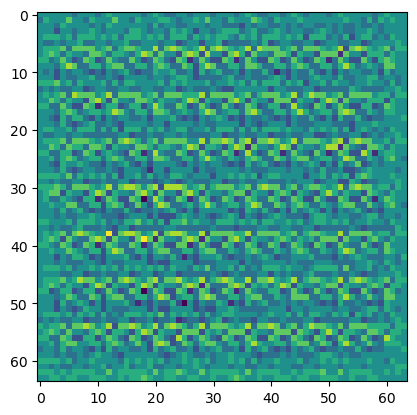

epoch = 1
Gen loss = tf.Tensor(0.02038592, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045130394, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 2
Gen loss = tf.Tensor(0.025053259, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04032429, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 3
Gen loss = tf.Tensor(0.022926597, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037630696, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 4
Gen loss = tf.Tensor(0.023137217, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041106537, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 5
Gen loss = tf.Tensor(0.024735253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043755785, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 6
Gen loss = tf.Tensor(0.019466314, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043380156, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 7
Gen loss = tf.Tensor(0.021456799, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044411097, shap

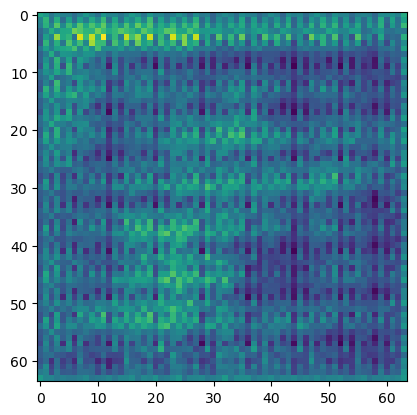

epoch = 11
Gen loss = tf.Tensor(0.016599905, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0626937, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 12
Gen loss = tf.Tensor(0.020792421, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05518675, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 13
Gen loss = tf.Tensor(0.019785779, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052800696, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 14
Gen loss = tf.Tensor(0.016957147, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055715267, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 15
Gen loss = tf.Tensor(0.020356955, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04936737, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 16
Gen loss = tf.Tensor(0.01953868, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.051288467, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 17
Gen loss = tf.Tensor(0.01901109, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052237686, s

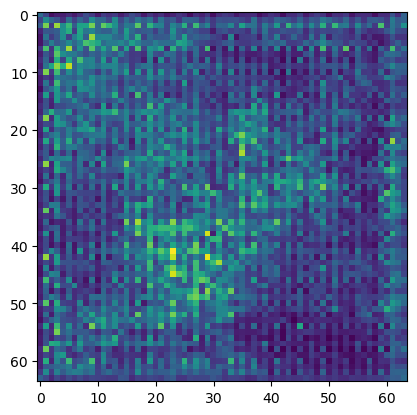

epoch = 21
Gen loss = tf.Tensor(0.017626705, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054242853, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 22
Gen loss = tf.Tensor(0.020490902, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050148234, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 23
Gen loss = tf.Tensor(0.018306738, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052208588, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 24
Gen loss = tf.Tensor(0.019715674, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05026577, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 25
Gen loss = tf.Tensor(0.019937107, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05076322, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 26
Gen loss = tf.Tensor(0.020061499, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048513636, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 27
Gen loss = tf.Tensor(0.019209692, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04978002

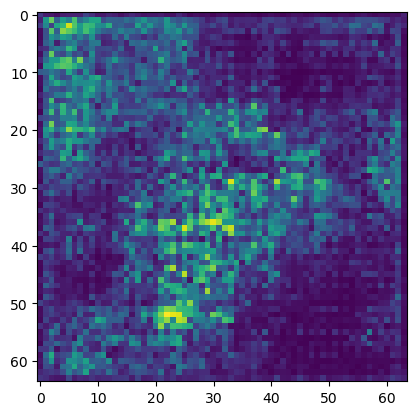

epoch = 31
Gen loss = tf.Tensor(0.021303354, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04775401, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 32
Gen loss = tf.Tensor(0.021029899, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04808718, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 33
Gen loss = tf.Tensor(0.020616943, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048216045, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 34
Gen loss = tf.Tensor(0.021330869, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048057776, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 35
Gen loss = tf.Tensor(0.020877609, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04823615, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 36
Gen loss = tf.Tensor(0.020335436, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04830923, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 37
Gen loss = tf.Tensor(0.021132817, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048098598,

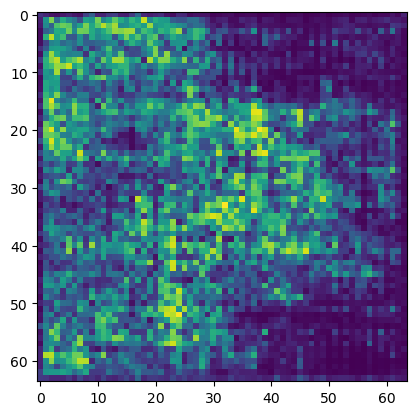

epoch = 41
Gen loss = tf.Tensor(0.021286724, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04789279, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 42
Gen loss = tf.Tensor(0.021703545, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04742236, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 43
Gen loss = tf.Tensor(0.021522513, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046981603, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 44
Gen loss = tf.Tensor(0.021774076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046690173, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 45
Gen loss = tf.Tensor(0.021885777, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046808742, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 46
Gen loss = tf.Tensor(0.02168604, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046617955, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 47
Gen loss = tf.Tensor(0.022589002, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046160415

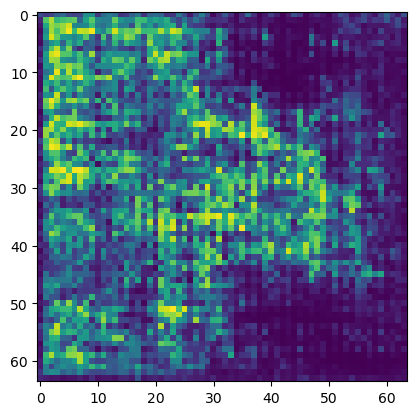

epoch = 51
Gen loss = tf.Tensor(0.022213846, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046267316, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 52
Gen loss = tf.Tensor(0.022131389, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045861218, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 53
Gen loss = tf.Tensor(0.021556893, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04611022, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 54
Gen loss = tf.Tensor(0.022296725, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046251953, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 55
Gen loss = tf.Tensor(0.02227066, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045597907, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 56
Gen loss = tf.Tensor(0.022690073, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045480475, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 57
Gen loss = tf.Tensor(0.022725927, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04537565

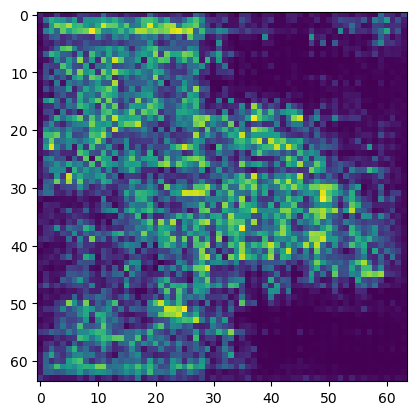

epoch = 61
Gen loss = tf.Tensor(0.021525452, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045629613, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 62
Gen loss = tf.Tensor(0.022159625, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04505108, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 63
Gen loss = tf.Tensor(0.02326429, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04510084, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 64
Gen loss = tf.Tensor(0.022303563, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045192536, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 65
Gen loss = tf.Tensor(0.022550557, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044887174, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 66
Gen loss = tf.Tensor(0.022975635, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045422785, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 67
Gen loss = tf.Tensor(0.023271265, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044491902

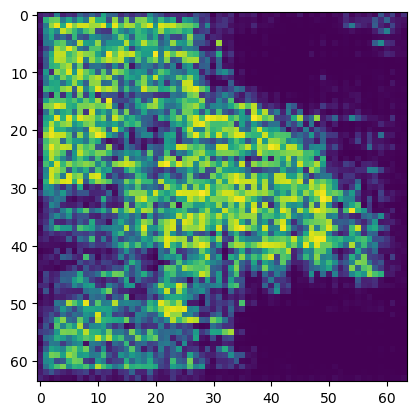

epoch = 71
Gen loss = tf.Tensor(0.023699787, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044869654, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 72
Gen loss = tf.Tensor(0.022385994, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04451199, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 73
Gen loss = tf.Tensor(0.022718936, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043197453, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 74
Gen loss = tf.Tensor(0.023656832, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04589373, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 75
Gen loss = tf.Tensor(0.023708414, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04423284, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 76
Gen loss = tf.Tensor(0.023417078, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043959625, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 77
Gen loss = tf.Tensor(0.02344351, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04416456, 

In [253]:

gen_losses, disc_losses, generated_map, disc_accuracies = train(training_data, N_EPOCHS)


Denormalize, save and display generated map output

(64, 64)


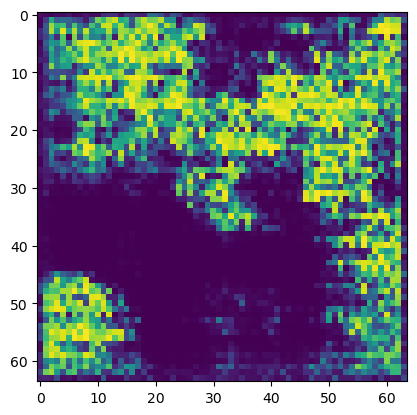

In [254]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()


plt.imshow(generated_map)

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

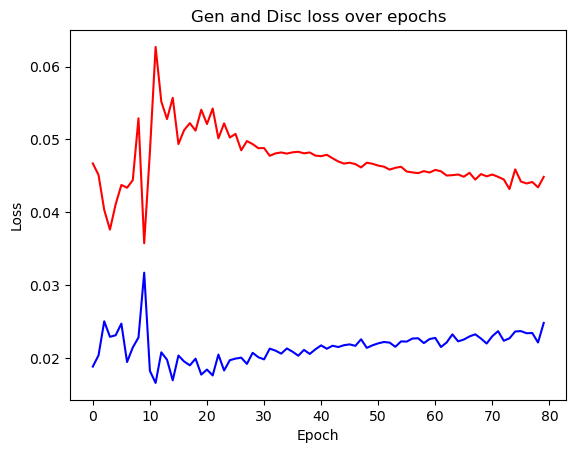

In [255]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1520,) + inhomogeneous part.

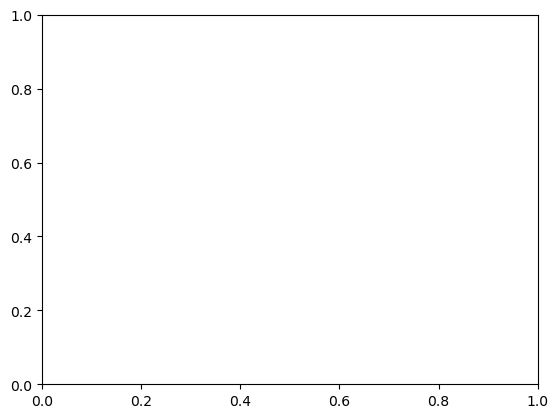

In [256]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')